# Лабораторная работа №3
# Дискретные каналы связи

## Описание:
В данной лабораторной работе предлагается исследовать модели дискретных каналов, рассчитать пропускную способность для различных типов каналов, а также провести анализ влияния параметров канала на его пропускную способность.

## Ход работы:

### Дискретный канал

Дискретный канал можно описать следующими тремя величинами $(X, p(y|x), Y)$:
- $X = \{x_0, x_1, ..., x_{m-1}\}$ — входной алфавит (m символов)
- $Y = \{y_0, y_1, ..., y_{n-1}\}$ — выходной алфавит (n символов)
- $p(y|x)$ — матрица переходов (условные вероятности)

**Пропускная способность:**

$$C = \max_{p(X)} I(X;Y) = \max_{p(X)} [H(Y) - H(Y|X)]$$

где взаимная информация:

$$I(X;Y) = \sum_{x \in X} \sum_{y \in Y} p(x,y) \log_2 \frac{p(x,y)}{p(x)p(y)}$$

Пропускную способность будем получать путем численной оптимизации входного распределения для максимизации взаимной информации (через градиент с учетом ограничений на вероятности). Полученные значения сравним с теоретическими формулами (в тех, случаях, когда таковые есть).

### Необходимые инструменты

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def binary_entropy(p): # H(p)
    if p == 0 or p == 1:
        return 0
    return -(p * np.log2(p) + (1-p) * np.log2(1-p))

def mutual_information(p_x, transition_matrix): # I(X, Y)
    # transition_matrix - (n_outputs)x(n_inputs)
    # p_x - (n_inputs,)

    p_y = transition_matrix @ p_x
    
    # I(X, Y)
    mutual_info = 0
    n_inputs = len(p_x)
    n_outputs = transition_matrix.shape[0]
    
    for i in range(n_inputs):
        if p_x[i] > 1e-10:
            for j in range(n_outputs):
                p_yj_xi = transition_matrix[j, i]  # P(y_j | x_i)
                if p_yj_xi > 1e-10 and p_y[j] > 1e-10:
                    mutual_info += p_x[i] * p_yj_xi * np.log2(p_yj_xi / p_y[j])
    
    return mutual_info

def channel_capacity_discrete(transition_matrix):
    # transition_matrix - (n_outputs)x(n_inputs)
    n_inputs = transition_matrix.shape[1]
    
    def objective(p_x):
        return -mutual_information(p_x, transition_matrix)
    
    constraints = {'type': 'eq', 'fun': lambda p: np.sum(p) - 1}
    bounds = [(0, 1) for _ in range(n_inputs)]
    
    # Initial assumption
    p_x_init = np.ones(n_inputs) / n_inputs
    
    result = minimize(objective, p_x_init, method='SLSQP',
                     bounds=bounds, constraints=constraints,
                     options={'ftol': 1e-12})
    
    return -result.fun, result.x


### 1) Бинарный симметричный канал (BSC)
`BSC` — канал с двумя входами и выходами (0, 1), где для каждого бита вероятность искажения при передаче (инверсия) - `р`.

In [2]:
print("="*70)
print("1) Бинарный симметричный канал (BSC)")
print("="*70)

error_probs = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5])

print(f"\n{'Вероятность':<15} {'Пропускная':<20} {'Оптимальное':<20}")
print(f"{'ошибки p':<15} {'способность (бит)':<20} {'распределение':<20}")
print("-"*70)

capacities_bsc = []
for p_err in error_probs:
    transition_matrix = np.array([
        [1 - p_err, p_err],
        [p_err, 1 - p_err]
    ]).T
    
    capacity, p_opt = channel_capacity_discrete(transition_matrix)
    capacities_bsc.append(capacity)
    
    theory_capacity = 1 - binary_entropy(p_err)
    
    print(f"{p_err:<15.2f} {capacity:<20.4f} p(0)={p_opt[0]:.3f}, p(1)={p_opt[1]:.3f}")

1) Бинарный симметричный канал (BSC)

Вероятность     Пропускная           Оптимальное         
ошибки p        способность (бит)    распределение       
----------------------------------------------------------------------
0.01            0.9192               p(0)=0.500, p(1)=0.500
0.05            0.7136               p(0)=0.500, p(1)=0.500
0.10            0.5310               p(0)=0.500, p(1)=0.500
0.15            0.3902               p(0)=0.500, p(1)=0.500
0.20            0.2781               p(0)=0.500, p(1)=0.500
0.30            0.1187               p(0)=0.500, p(1)=0.500
0.40            0.0290               p(0)=0.500, p(1)=0.500
0.50            0.0000               p(0)=0.500, p(1)=0.500


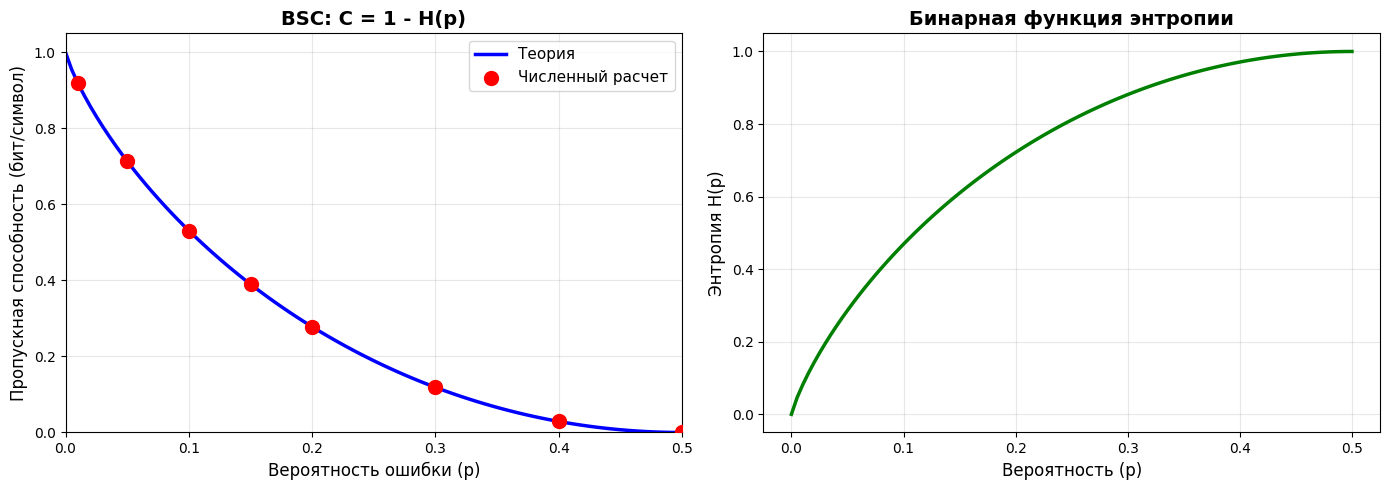

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Capacity vs error
error_range = np.linspace(0, 0.5, 100)
capacity_range_theory = [1 - binary_entropy(p) for p in error_range]

axes[0].plot(error_range, capacity_range_theory, 'b-', linewidth=2.5, label='Теория')
axes[0].scatter(error_probs, capacities_bsc, color='red', s=100, 
                label='Численный расчет', zorder=5)
axes[0].set_xlabel('Вероятность ошибки (p)', fontsize=12)
axes[0].set_ylabel('Пропускная способность (бит/символ)', fontsize=12)
axes[0].set_title('BSC: C = 1 - H(p)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)
axes[0].set_xlim([0, 0.5])
axes[0].set_ylim([0, 1.05])

# Plot 2: Entropy
entropy_range = [binary_entropy(p) for p in error_range]
axes[1].plot(error_range, entropy_range, 'g-', linewidth=2.5)
axes[1].set_xlabel('Вероятность (p)', fontsize=12)
axes[1].set_ylabel('Энтропия H(p)', fontsize=12)
axes[1].set_title('Бинарная функция энтропии', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Видно, что пропускная способность линейно зависит от энтропии, причем чем выше энтропия, тем меньше передается полезной информации (больше неопределенность). Помимо этого заметим, что оптимальное распределение `Х` всегда равномерно, что ожидаемо вследствие симметрии канала. Наконец отметим допустимые диапазоны ошибок, когда еще есть смысл работать с таким каналом: 1) `p < 0.05 -> C > 0.7 бит` (нормально); 2) `0.05 < p < 0.2 -> C падает в 2 раза и больше`; 3) `p > 0.3 -> C < 0.1 бит` (канал бесполезен).

### 2) Стирающий канал (BEC)
`BEC` — канал с двумя входами, но тремя выходами, так как символ может быть стерт (потерян) с вероятностью `ε`, что дает нам дополнительный выход `e`.

In [4]:
print("\n" + "="*70)
print("2) Стирающий бинарный канал (BEC)")
print("="*70)

erasure_probs = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

print(f"\n{'Вероятность':<15} {'Пропускная':<20} {'Оптимальное распределение':<30}")
print(f"{'стирания ε':<15} {'способность (бит)':<20} {'p(0), p(1)':<30}")
print("-"*70)

distributions_bec = []
capacities_bec = []

for p_erase in erasure_probs:
    transition_matrix_bec = np.array([
        [1 - p_erase, 0],           # 0
        [0, 1 - p_erase],           # 1
        [p_erase, p_erase]          # e
    ])
    
    capacity, p_opt = channel_capacity_discrete(transition_matrix_bec)
    capacities_bec.append(capacity)
    distributions_bec.append(p_opt)
    
    theory_capacity = 1 - p_erase
    
    print(f"{p_erase:<15.2f} {capacity:<20.4f} p(0)={p_opt[0]:.4f}, p(1)={p_opt[1]:.4f}")



2) Стирающий бинарный канал (BEC)

Вероятность     Пропускная           Оптимальное распределение     
стирания ε      способность (бит)    p(0), p(1)                    
----------------------------------------------------------------------
0.00            1.0000               p(0)=0.5000, p(1)=0.5000
0.10            0.9000               p(0)=0.5000, p(1)=0.5000
0.20            0.8000               p(0)=0.5000, p(1)=0.5000
0.30            0.7000               p(0)=0.5000, p(1)=0.5000
0.40            0.6000               p(0)=0.5000, p(1)=0.5000
0.50            0.5000               p(0)=0.5000, p(1)=0.5000


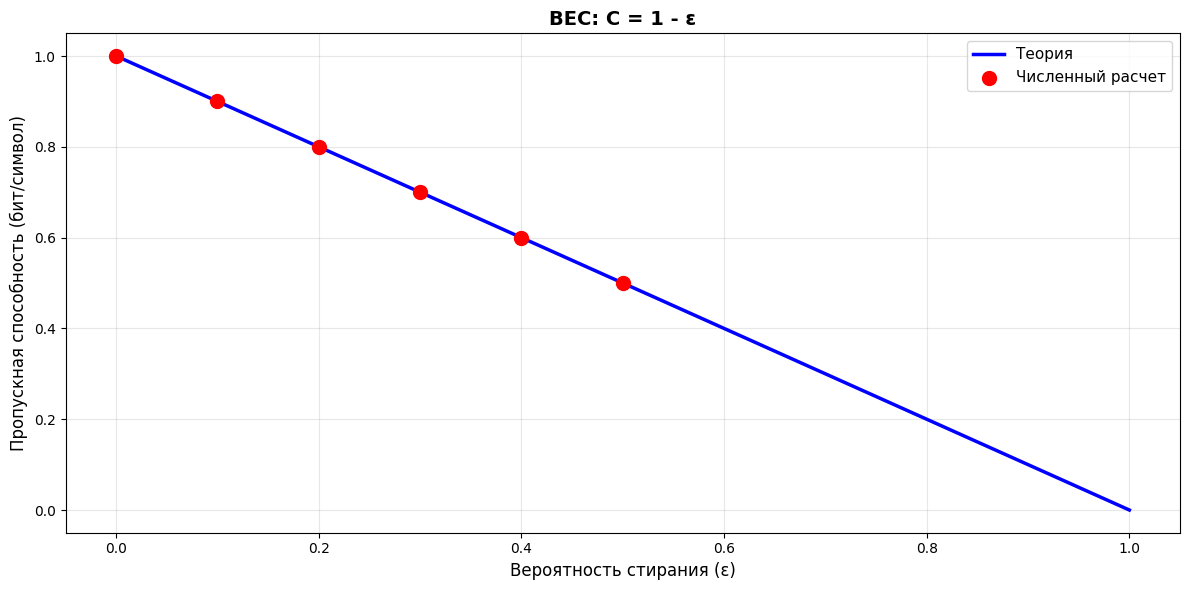

In [5]:
erasure_range = np.linspace(0, 1, 100)
capacity_range_bec_theory = [1 - eps for eps in erasure_range]

plt.figure(figsize=(12, 6))
plt.plot(erasure_range, capacity_range_bec_theory, 'b-', linewidth=2.5, label='Теория')
plt.scatter(erasure_probs, capacities_bec, color='red', s=100, 
            label='Численный расчет', zorder=5)
plt.xlabel('Вероятность стирания (ε)', fontsize=12)
plt.ylabel('Пропускная способность (бит/символ)', fontsize=12)
plt.title('BEC: C = 1 - ε', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

В случае этого канала видим, что при схожих вероятностях ошибки (либо стирания/потери) `BEC` имеет большую пропускную способность, нежели `BSC`. Так, при $p = \varepsilon = 0.1$ имеем $C_{BSC} = 0.532$ и $C_{BEC} = 0.900$, что можно объяснить наличием информации об ошибке (в случае `BSC` нельзя понять, получили мы инвертированный бит на выходе или же исходный).

### 3) Z-канал (асимметричный)
`Z-канал` — опять же двухвходовой с двумя выходами, однако теперь асимметричный канал, где только передача `1` может быть ошибочной (инверсия).

In [6]:
print("\n" + "="*70)
print("3) Z-канал (асимметричный бинарный канал)")
print("="*70)

z_error_probs = np.array([0.01, 0.05, 0.1, 0.15, 0.2, 0.3])

print(f"\n{'Вероятность':<15} {'Пропускная':<20} {'Оптимальное':<25}")
print(f"{'ошибки p':<15} {'способность (бит)':<20} {'распределение':<25}")
print("-"*70)

capacities_z = []
for p_err in z_error_probs:
    # Z-канал: P(1|0)=p, P(0|1)=0, P(1|1)=1-p
    transition_matrix_z = np.array([
        [1,     p_err],           # 0
        [0, 1 - p_err]            # 1
    ])
    
    capacity, p_opt = channel_capacity_discrete(transition_matrix_z)
    capacities_z.append(capacity)
    
    print(f"{p_err:<15.2f} {capacity:<20.4f} p(0)={p_opt[0]:.3f}, p(1)={p_opt[1]:.3f}")


3) Z-канал (асимметричный бинарный канал)

Вероятность     Пропускная           Оптимальное              
ошибки p        способность (бит)    распределение            
----------------------------------------------------------------------
0.01            0.9598               p(0)=0.509, p(1)=0.491
0.05            0.8571               p(0)=0.528, p(1)=0.472
0.10            0.7628               p(0)=0.544, p(1)=0.456
0.15            0.6854               p(0)=0.555, p(1)=0.445
0.20            0.6182               p(0)=0.564, p(1)=0.436
0.30            0.5037               p(0)=0.579, p(1)=0.421


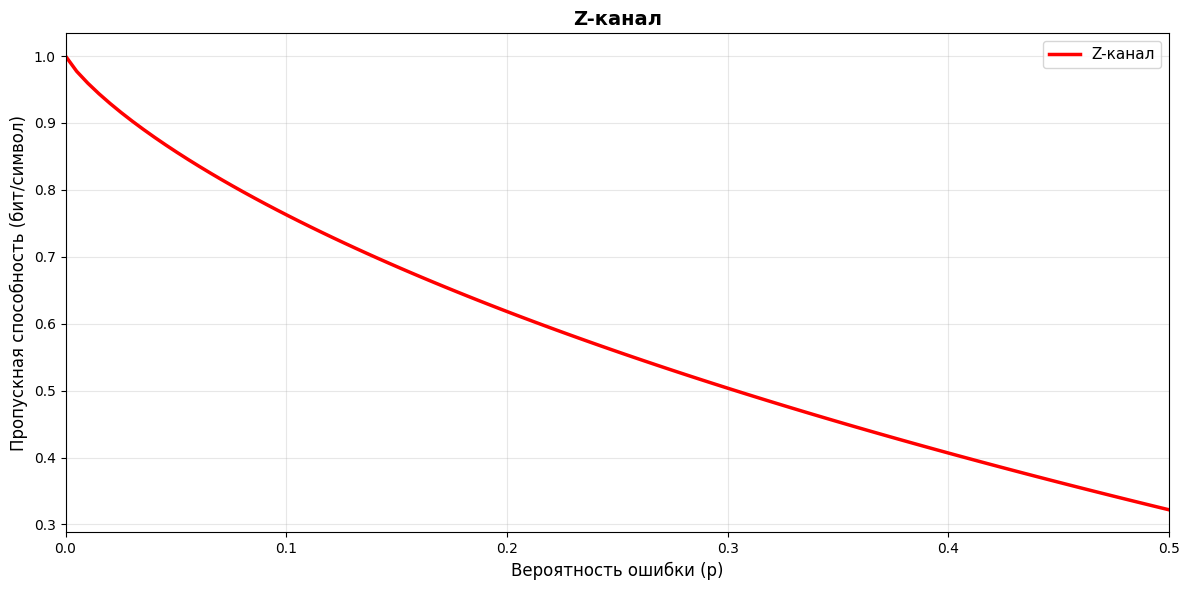

In [7]:
plt.figure(figsize=(12, 6))

z_range = np.linspace(0, 0.5, 100)
bsc_range = [1 - binary_entropy(p) for p in z_range]

z_capacity_range = []
for p in z_range:
    tm = np.array([
        [1,     p],
        [0, 1 - p]
    ])
    cap, _ = channel_capacity_discrete(tm)
    z_capacity_range.append(cap)

plt.plot(z_range, z_capacity_range, 'r-', linewidth=2.5, label='Z-канал')
plt.xlabel('Вероятность ошибки (p)', fontsize=12)
plt.ylabel('Пропускная способность (бит/символ)', fontsize=12)
plt.title('Z-канал', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xlim([0, 0.5])
plt.tight_layout()
plt.show()

Здесь заметим, что оптимальное распределение можно примерно описать как: `p(0) = 0.6, p(1) = 0.4`, что может быть обусловлено более надежной передачей `0`. Заметим также, что при равных вероятностях ошибок `Z-канал` дает большую пропускную способность, чем `BSC`.

### 4) Параметрическое исследование
Сравнение пропускной способности различных типов дискретных каналов

In [8]:
channel_families = {
    'BSC': [],
    'BEC': [],
    'Z-channel': []
}

parameters = np.linspace(0.01, 0.49, 20)

# BSC
for p in parameters:
    tm = np.array([[1-p, p], [p, 1-p]]).T
    cap, _ = channel_capacity_discrete(tm)
    channel_families['BSC'].append((p, cap))

# BEC
for eps in parameters:
    tm = np.array([
        [1-eps, 0],
        [0, 1-eps],
        [eps, eps]
    ])
    cap, _ = channel_capacity_discrete(tm)
    channel_families['BEC'].append((eps, cap))

# Z-channel
for p in parameters:
    tm = np.array([
        [1,     p],
        [0, 1 - p]
    ])
    cap, _ = channel_capacity_discrete(tm)
    channel_families['Z-channel'].append((p, cap))

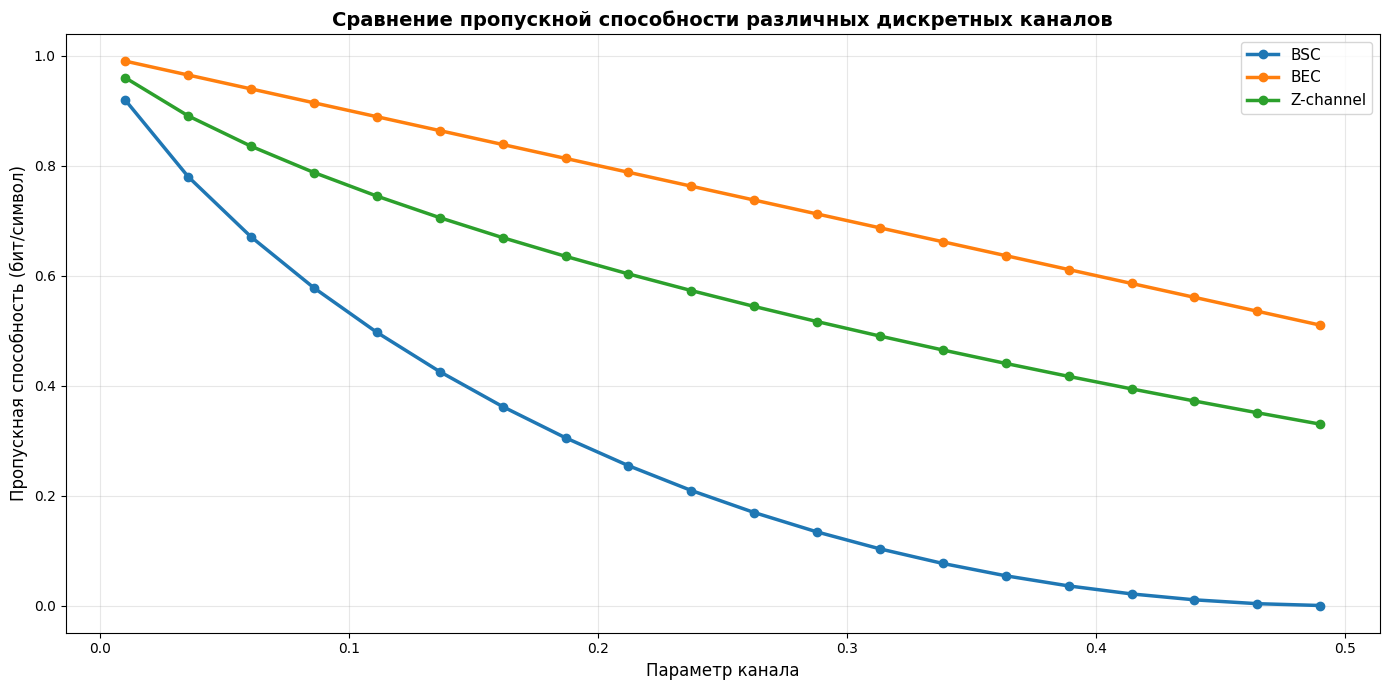

In [9]:
plt.figure(figsize=(14, 7))

for name, data in channel_families.items():
    params, caps = zip(*data)
    plt.plot(params, caps, linewidth=2.5, marker='o', label=name, markersize=6)

plt.xlabel('Параметр канала', fontsize=12)
plt.ylabel('Пропускная способность (бит/символ)', fontsize=12)
plt.title('Сравнение пропускной способности различных дискретных каналов', 
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()


## Выводы:
В данной лабораторной работе мы исследовали различные каналы (`BSC`, `BEC`, `Z-канал`), измерив их пропускную способность при разных значениях вероятности ошибки `p`, а также нашли оптимальные распределения для каждого из них. По последнему графику видно, что при $p \approx 0.5$ (макс. неопределенность) происходит деградация каналов, однако за счет фиксации ошибок (стирание), либо их асимметрии (переход только из 1 в 0) `BEC` и `Z-канал` теряют меньше в пропускной способности. Следует также заметить, что оптимальное распределение во многом определяется симметричностью структуры ошибок. Так, `BSC` и `BEC` (симметричные каналы) имеют равномерное распределение, а `Z-канал` (асимметричный) - `p(0) = 0.6, p(1) = 0.4`.